In [1]:
import os
from torch.utils.data import Dataset
import torch
import numpy as np


class CC200Data(Dataset):
    def __init__(self, region_path, subnet_path, mapping, labels):
        super().__init__()
        self.region_path = region_path
        self.subnet_path = subnet_path
        self.region_files = os.listdir(self.region_path)
        self.subnet_files = os.listdir(self.subnet_path)
        self.labels_dict = labels  
        self.region_indices = mapping

        self.values = []
        for key in self.labels_dict:
            result = self._load_data(key)
            if result is not None:
                self.values.append(result)

        self.labels = torch.tensor([item[2] for item in self.values])
        self.region_coeffs = torch.stack([item[0] for item in self.values])
        self.subnet_coeffs = [item[1] for item in self.values]

        self.region_start_indices = {}
        keys = list(self.region_indices.keys())
        for i in range(len(keys)):
            if i == 0:
                self.region_start_indices[keys[i]] = 0
            else:
                prev_key = keys[i - 1]
                self.region_start_indices[keys[i]] = self.region_start_indices[prev_key] + len(self.region_indices[prev_key])

    def _load_data(self, filename):
        region_file = os.path.join(self.region_path, filename + "_func_preproc_corr.npy")
        subnet_file = os.path.join(self.subnet_path, filename + "_func_preproc_corr.npz")

        try:
            region_data = np.load(region_file)
            if np.isnan(region_data).any():
                return None
            region_tensor = torch.tensor(region_data, dtype=torch.float32)

            subnet_data = np.load(subnet_file)
            subnet_matrices = []
            for key in subnet_data.files:
                arr = subnet_data[key]
                if np.isnan(arr).any():
                    return None
                subnet_matrices.append(torch.tensor(self._flatten_matrix(arr), dtype=torch.float32))

            label = self.labels_dict[filename]
            return region_tensor, subnet_matrices, label

        except Exception as e:
            print(f"Failed to load {filename}: {e}")
            return None

    def _flatten_matrix(self, matrix):
        idx = np.triu_indices_from(matrix, k=1)
        return matrix[idx]

    def __len__(self):
        return len(self.values)

    def __getitem__(self, idx):
        region_corr = self.region_coeffs[idx]
        subnet_corrs = self.subnet_coeffs[idx]
        label = self.labels[idx]
        return region_corr, subnet_corrs, label

In [2]:
# !wget https://raw.githubusercontent.com/broccubali/AutisticAdventures/main/src/mapping.json
# !wget https://s3.amazonaws.com/fcp-indi/data/Projects/ABIDE_Initiative/Phenotypic_V1_0b_preprocessed1.csv

In [3]:
import json

with open("mapping.json", "r") as f:
    mapping = json.load(f)

In [4]:
import pandas as pd
df = pd.read_csv("Phenotypic_V1_0b_preprocessed1.csv")
df = df[["FILE_ID", "DX_GROUP"]]
labels_mapping = dict(zip(df["FILE_ID"], df["DX_GROUP"]))

In [7]:
# had to fix this here cuz pytorch cross entropy loss needs 0 and 1 not 1 and 2
new_labels_mapping = {}
for key, value in labels_mapping.items():
    new_labels_mapping[key] = value - 1  # Subtract 1 to convert 1,2 to 0,1

# Recreate your dataset with adjusted labels
dataset = CC200Data("region_corr", "subnet_corr", mapping, new_labels_mapping)

Failed to load no_filename: [Errno 2] No such file or directory: 'region_corr/no_filename_func_preproc_corr.npy'


In [8]:
from torch.utils.data import DataLoader, random_split
train_ratio = 0.8 
val_ratio = 0.2  

train_size = int(train_ratio * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

In [9]:
unique_labels = set()
for _, _, labels in train_loader:
    unique_labels.update(labels.numpy())
print(f"updated label values: {sorted(list(unique_labels))}")

updated label values: [0, 1]


In [10]:
shapes = []
a = next(iter(dataset))[1]
for i in a:
    shapes.append(i.shape[0])

# len(shapes)

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MHSA(nn.Module):
    def __init__(self, embd_dim, num_heads):
        super().__init__()
        self.embd_dim = embd_dim
        self.num_heads = num_heads
        self.head_size = self.embd_dim // self.num_heads
        self.q = nn.Linear(self.embd_dim, self.embd_dim)
        self.k = nn.Linear(self.embd_dim, self.embd_dim)
        self.v = nn.Linear(self.embd_dim, self.embd_dim)
        self.d = self.head_size ** 0.5
        self.mlp = nn.Linear(self.embd_dim, self.embd_dim)
        self.layer_norm = nn.LayerNorm(self.embd_dim)  
        
    def forward(self, x, subnet=False):
        batch_size, M, _ = x.shape
        norm = self.layer_norm(x)
        q = self.q(norm).view(batch_size, M, self.num_heads, self.head_size).transpose(1, 2)
        k = self.k(norm).view(batch_size, M, self.num_heads, self.head_size).transpose(1, 2)
        v = self.v(norm).view(batch_size, M, self.num_heads, self.head_size).transpose(1, 2)
        attn_scores = torch.matmul(q, k.transpose(-2, -1)) / self.d
        # if not subnet:
        attn_scores = attn_scores.masked_fill(torch.eye(M, device=x.device).bool(), float('-inf'))
        attn_weights = F.softmax(attn_scores, dim=-1)
        context = torch.matmul(attn_weights, v).transpose(1, 2).reshape(batch_size, M, self.embd_dim)
        out = self.mlp(context)
        return out + x, attn_weights

In [12]:
class SubnetworkEmbedder(nn.Module):
    def __init__(self, input_dim, hidden_dim=256, output_dim=128, dropout=0.3):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, output_dim),
        )

    def forward(self, x):
        return self.mlp(x)

In [13]:
class RegionEmbedder(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout=0.3):
        super().__init__()
        self.region_conv = nn.Conv2d(1, 1, kernel_size=1)
        self.mlp = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),            
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, output_dim),
        )       

    def forward(self, x):
        x_conv = self.region_conv(x.unsqueeze(1)) 
        x_conv = x_conv.squeeze(1)  
        return self.mlp(x_conv)

In [14]:
class RegionEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, embd_dim, num_heads, num_layers):
        super().__init__()
        self.reg_embd = RegionEmbedder(input_dim, hidden_dim, embd_dim)
        self.mhsa_layers = nn.ModuleList([MHSA(embd_dim, num_heads) for _ in range(num_layers)])

    def forward(self, x):
        x_reg = self.reg_embd(x)
        x_in = x_reg
        attn_weights_all = []
        for mhsa in self.mhsa_layers:
            x_in, attn_weights = mhsa(x_in)
            attn_weights_all.append(attn_weights)
        return x_reg + x_in, torch.stack(attn_weights_all).permute(1, 0, 2, 3, 4)

In [15]:
class SubNetworkEncoder(nn.Module):
    def __init__(self, shapes, hidden_dim, embd_dim, num_heads, num_layers):
        super().__init__()
        self.embd_dim = embd_dim
        self.mlps = nn.ModuleList([SubnetworkEmbedder(i, hidden_dim, embd_dim) for i in shapes])
        self.mhsa_layers = nn.ModuleList([MHSA(embd_dim, num_heads) for _ in range(num_layers)])

    def forward(self, x):
        x = torch.stack([mlp(f) for mlp, f in zip(self.mlps, x)], dim=1)
        attn_weights_all = []
        for mhsa in self.mhsa_layers:
            x, attn_weights = mhsa(x, True)
            attn_weights_all.append(attn_weights)

        return x, torch.stack(attn_weights_all).permute(1, 0, 2, 3, 4)

In [16]:
class StepOne(nn.Module):
    def __init__(self, input_dim, hidden_dim, embd_dim, num_heads, num_layers):
        super().__init__()
        self.reg_enc = RegionEncoder(input_dim, hidden_dim, embd_dim, num_heads, num_layers)
        self.subnet_enc = SubNetworkEncoder(shapes, hidden_dim, embd_dim, num_heads, num_layers)
        self.layer_norm = nn.LayerNorm(embd_dim)
        self.mlp = nn.Sequential(
            nn.Linear(embd_dim, hidden_dim),  
            nn.ReLU(),             
            nn.Linear(hidden_dim, embd_dim)    
        )
        self.region_start_indices = list(dataset.region_start_indices.values()) + [185]

    def subNetworkAttendRegions(self, subnet_attn_map, region_attn_map):
        region_to_subnet = torch.zeros(185, dtype=torch.long)
        for subnet_id in range(7):
            start = self.region_start_indices[subnet_id]
            end = self.region_start_indices[subnet_id + 1]
            region_to_subnet[start:end] = subnet_id  
        subnet_i = region_to_subnet.view(-1, 1).expand(185, 185) 
        subnet_j = region_to_subnet.view(1, -1).expand(185, 185)  

        mask = subnet_i != subnet_j  

        attn_multiplier = subnet_attn_map[:, :, :, subnet_i, subnet_j]  
        attn_multiplier = attn_multiplier * mask

        return region_attn_map * attn_multiplier 
    
    def sinkhorn(self, attn, n_iters=5, eps=1e-6):
        attn = attn + eps  
        for _ in range(n_iters):
            attn = attn / attn.sum(dim=-1, keepdim=True)
            attn = attn / attn.sum(dim=-2, keepdim=True)
        return attn
    
    def forward(self, x):
        x0 = self.reg_enc(x[0])
        x1 = self.subnet_enc(x[1])
        o = torch.cat((x0[0], x1[0]), dim=1)
        o_norm = self.layer_norm(o)
        o_norm = self.mlp(o)
        o = o + o_norm
        o_reg = o[:, :185, :]
        o_sub = o[:, 185:, :]
        adj_matrix = self.subNetworkAttendRegions(x1[1], x0[1])
        adj_matrix = self.sinkhorn(adj_matrix)
        return o_reg, o_sub, adj_matrix

# HGCN part now

In [17]:
class HGCN(nn.Module):
    def __init__(self, input_dim, output_dim, num_layers=4, num_heads=16):
        super().__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.num_layers = num_layers
        self.num_heads = num_heads

        # One linear layer per head per layer: (L, H, in, out)
        self.W = nn.Parameter(torch.randn(num_layers, num_heads, input_dim, output_dim))
        self.activation = nn.ReLU()

    def forward(self, features, attention_maps):
        """
        features: [B, N, F_in]
        attention_maps: [B, L, H, N, N] — soft adjacency or incidence maps
        """
        B, L, H, N, _ = attention_maps.shape
        F_in, F_out = self.input_dim, self.output_dim

        # Apply W to input features: [B, 1, 1, N, F_in] x [L, H, F_in, F_out]
        # -> output: [B, L, H, N, F_out]
        features_exp = features[:, None, None, :, :]  # [B, 1, 1, N, F_in]
        weights = self.W[None, :, :, :, :]            # [1, L, H, F_in, F_out]
        transformed = torch.matmul(features_exp, weights)  # [B, L, H, N, F_out]
        # Apply hypergraph attention maps
        # attention_maps: [B, L, H, N, N]
        # transformed:     [B, L, H, N, F_out]
        output = torch.matmul(attention_maps, transformed)  # [B, L, H, N, F_out]
        output = self.activation(output)

        # Concatenate heads → [B, L, N, H * F_out]
        output = output.permute(0, 1, 3, 2, 4).reshape(B, L, N, H * F_out)

        # Concatenate layers → [B, N, L * H * F_out]
        output = output.permute(0, 2, 1, 3).reshape(B, N, L * H * F_out)

        return output

In [18]:
class StepOneWithHGCN(nn.Module):
    def __init__(self, input_dim, hidden_dim, embd_dim, num_heads, num_layers, mapping, num_classes=2, dropout=0.3):
        super().__init__()
        # Copy paste
        self.reg_enc = RegionEncoder(input_dim, hidden_dim, embd_dim, num_heads, num_layers)
        self.subnet_enc = SubNetworkEncoder(shapes, hidden_dim, embd_dim, num_heads, num_layers)
        self.layer_norm = nn.LayerNorm(embd_dim)
        self.mlp = nn.Sequential(
            nn.Linear(embd_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, embd_dim)
        )
        self.region_start_indices = list(dataset.region_start_indices.values()) + [185]
        self.hgcn = HGCN(input_dim=embd_dim, output_dim=embd_dim//num_heads, num_layers=num_layers, num_heads=num_heads)
        hgcn_output_dim = (embd_dim//num_heads) * num_heads * num_layers
        self.classifier = nn.Sequential(
            nn.Linear(hgcn_output_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, num_classes)
        )
        self.index_map = self.make_index_map(mapping)

    def make_index_map(self, mapping):
        index_map = {}  
        
        for i in range(7):
            for j in range(7):
                a = torch.tensor(list(mapping.values())[i])
                b = torch.tensor(list(mapping.values())[j])
                aa, bb = torch.meshgrid(a, b, indexing='ij')
                index_map[(i, j)] = (aa.flatten(), bb.flatten())
        return index_map
    
    def subNetworkAttendRegions(self, x, y):
        for i in range(7):
            for j in range(7):
                aa, bb = self.index_map[(i, j)]  
        
                x_slice = x[:, :, :, i, j].unsqueeze(-1)  
                y[:, :, :, aa, bb] *= x_slice
        return y
    
    def sinkhorn(self, attn, n_iters=5, eps=1e-6):
        attn = attn + eps
        for _ in range(n_iters):
            attn = attn / attn.sum(dim=-1, keepdim=True)
            attn = attn / attn.sum(dim=-2, keepdim=True)
        return attn
    
    def forward(self, x):
        x0, region_attn = self.reg_enc(x[0])
        x1, subnet_attn = self.subnet_enc(x[1])
        o = torch.cat((x0, x1), dim=1)
        # o = x0
        o_norm = self.layer_norm(o)
        o_norm = self.mlp(o_norm)
        o = o + o_norm
        o_reg = o[:, :100, :]  # First 185 nodes are regions
        o_sub = o[:, 100:, :]  # Remaining nodes are subnetworks
        # Process attention maps to create the combined attention 
        # with shape [batch_size, num_layers (4), num_heads (16), 185, 185]
        combined_attn = self.subNetworkAttendRegions(subnet_attn, region_attn)
        combined_attn = self.sinkhorn(combined_attn)
        # Pass through HGCN - only process the region features with the combined attention
        hgcn_output = self.hgcn(o_reg, combined_attn)
        
        # Global average pooling for classification
        pooled_output = hgcn_output.mean(dim=1)  # [batch_size, output_dim*num_heads*num_layers]
        # Final classif
        logits = self.classifier(pooled_output)
        return logits, combined_attn

In [21]:
from tqdm import tqdm

model = StepOneWithHGCN(
    input_dim=100,
    hidden_dim=256,
    embd_dim=128,
    num_heads=4,
    num_layers=2,
    mapping=mapping,
    num_classes=2
)

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()

num_epochs = 50
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    pbar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch+1}/{num_epochs}")
    
    for batch_idx, (region_data, subnet_data, labels) in pbar:
        region_data = region_data.to(device)
        subnet_data = [subnet.to(device) for subnet in subnet_data]
        labels = labels.to(device)

        optimizer.zero_grad()
        x = (region_data, subnet_data)
        logits, _ = model(x)
        loss = criterion(logits, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(logits.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        pbar.set_postfix({
            'Loss': f'{running_loss / (batch_idx + 1):.4f}',
            'Acc': f'{100 * correct / total:.2f}%'
        })

    # Validation phase
    model.eval()  # Set the model to evaluation mode (disables dropout, batchnorm, etc.)
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():  # Turn off gradient tracking for validation
        for region_data, subnet_data, labels in val_loader:
            region_data = region_data.to(device)
            subnet_data = [subnet.to(device) for subnet in subnet_data]
            labels = labels.to(device)
    
            x = (region_data, subnet_data)
            logits, _ = model(x)
            loss = criterion(logits, labels)

            val_loss += loss.item()
            _, predicted = torch.max(logits.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    # Print validation results after each epoch
    val_accuracy = 100 * val_correct / val_total
    val_loss /= len(val_loader)

    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

# Save the model after training
torch.save(model.state_dict(), 'brain_network_model.pth')


Epoch 1/50: 100%|██████████| 52/52 [00:01<00:00, 32.17it/s, Loss=0.7907, Acc=50.37%]


Validation Loss: 0.7992, Validation Accuracy: 52.68%


Epoch 2/50: 100%|██████████| 52/52 [00:01<00:00, 27.78it/s, Loss=0.7239, Acc=53.05%]


Validation Loss: 0.6861, Validation Accuracy: 53.17%


Epoch 3/50: 100%|██████████| 52/52 [00:01<00:00, 29.18it/s, Loss=0.7191, Acc=51.34%]


Validation Loss: 0.6859, Validation Accuracy: 54.63%


Epoch 4/50: 100%|██████████| 52/52 [00:01<00:00, 27.61it/s, Loss=0.7020, Acc=54.02%]


Validation Loss: 0.6791, Validation Accuracy: 55.61%


Epoch 5/50: 100%|██████████| 52/52 [00:01<00:00, 27.79it/s, Loss=0.7049, Acc=53.54%]


Validation Loss: 0.7008, Validation Accuracy: 48.29%


Epoch 6/50: 100%|██████████| 52/52 [00:01<00:00, 29.04it/s, Loss=0.6964, Acc=53.05%]


Validation Loss: 0.6747, Validation Accuracy: 55.61%


Epoch 7/50: 100%|██████████| 52/52 [00:01<00:00, 29.28it/s, Loss=0.6936, Acc=52.93%]


Validation Loss: 0.6957, Validation Accuracy: 53.66%


Epoch 8/50: 100%|██████████| 52/52 [00:01<00:00, 26.54it/s, Loss=0.7007, Acc=52.93%]


Validation Loss: 0.6838, Validation Accuracy: 52.20%


Epoch 9/50: 100%|██████████| 52/52 [00:01<00:00, 28.18it/s, Loss=0.6966, Acc=55.85%]


Validation Loss: 0.6624, Validation Accuracy: 61.46%


Epoch 10/50: 100%|██████████| 52/52 [00:01<00:00, 27.59it/s, Loss=0.6741, Acc=58.90%]


Validation Loss: 0.6788, Validation Accuracy: 54.63%


Epoch 11/50: 100%|██████████| 52/52 [00:01<00:00, 27.91it/s, Loss=0.6794, Acc=57.68%]


Validation Loss: 0.6549, Validation Accuracy: 63.90%


Epoch 12/50: 100%|██████████| 52/52 [00:01<00:00, 27.89it/s, Loss=0.6794, Acc=55.00%]


Validation Loss: 0.6528, Validation Accuracy: 63.41%


Epoch 13/50: 100%|██████████| 52/52 [00:02<00:00, 24.84it/s, Loss=0.6621, Acc=58.78%]


Validation Loss: 0.6521, Validation Accuracy: 62.44%


Epoch 14/50: 100%|██████████| 52/52 [00:02<00:00, 25.51it/s, Loss=0.6667, Acc=60.00%]


Validation Loss: 0.6690, Validation Accuracy: 57.07%


Epoch 15/50: 100%|██████████| 52/52 [00:01<00:00, 29.07it/s, Loss=0.6545, Acc=61.83%]


Validation Loss: 0.6416, Validation Accuracy: 61.95%


Epoch 16/50: 100%|██████████| 52/52 [00:01<00:00, 28.52it/s, Loss=0.6634, Acc=60.49%]


Validation Loss: 0.6491, Validation Accuracy: 58.54%


Epoch 17/50: 100%|██████████| 52/52 [00:01<00:00, 28.22it/s, Loss=0.6573, Acc=58.54%]


Validation Loss: 0.6650, Validation Accuracy: 61.46%


Epoch 18/50: 100%|██████████| 52/52 [00:01<00:00, 27.92it/s, Loss=0.6402, Acc=63.29%]


Validation Loss: 0.6559, Validation Accuracy: 60.98%


Epoch 19/50: 100%|██████████| 52/52 [00:01<00:00, 27.97it/s, Loss=0.6254, Acc=65.24%]


Validation Loss: 0.6482, Validation Accuracy: 60.98%


Epoch 20/50: 100%|██████████| 52/52 [00:01<00:00, 30.76it/s, Loss=0.6525, Acc=62.20%]


Validation Loss: 0.6582, Validation Accuracy: 61.46%


Epoch 21/50: 100%|██████████| 52/52 [00:01<00:00, 28.73it/s, Loss=0.6285, Acc=63.90%]


Validation Loss: 0.6940, Validation Accuracy: 53.66%


Epoch 22/50: 100%|██████████| 52/52 [00:01<00:00, 29.32it/s, Loss=0.6215, Acc=67.32%]


Validation Loss: 0.6460, Validation Accuracy: 61.95%


Epoch 23/50: 100%|██████████| 52/52 [00:01<00:00, 26.08it/s, Loss=0.6341, Acc=64.63%]


Validation Loss: 0.6401, Validation Accuracy: 64.39%


Epoch 24/50: 100%|██████████| 52/52 [00:01<00:00, 27.23it/s, Loss=0.6106, Acc=66.59%]


Validation Loss: 0.6562, Validation Accuracy: 64.39%


Epoch 25/50: 100%|██████████| 52/52 [00:02<00:00, 19.58it/s, Loss=0.6014, Acc=67.32%]


Validation Loss: 0.7044, Validation Accuracy: 60.00%


Epoch 26/50: 100%|██████████| 52/52 [00:01<00:00, 26.61it/s, Loss=0.5999, Acc=68.90%]


Validation Loss: 0.6518, Validation Accuracy: 62.93%


Epoch 27/50: 100%|██████████| 52/52 [00:02<00:00, 21.79it/s, Loss=0.6376, Acc=62.68%]


Validation Loss: 0.6583, Validation Accuracy: 56.59%


Epoch 28/50: 100%|██████████| 52/52 [00:02<00:00, 21.57it/s, Loss=0.6344, Acc=64.63%]


Validation Loss: 0.8532, Validation Accuracy: 54.63%


Epoch 29/50: 100%|██████████| 52/52 [00:02<00:00, 20.22it/s, Loss=0.6035, Acc=68.41%]


Validation Loss: 0.6362, Validation Accuracy: 63.90%


Epoch 30/50: 100%|██████████| 52/52 [00:01<00:00, 30.42it/s, Loss=0.5857, Acc=69.39%]


Validation Loss: 0.8104, Validation Accuracy: 55.12%


Epoch 31/50: 100%|██████████| 52/52 [00:01<00:00, 30.35it/s, Loss=0.6116, Acc=66.46%]


Validation Loss: 0.6546, Validation Accuracy: 67.32%


Epoch 32/50: 100%|██████████| 52/52 [00:01<00:00, 30.52it/s, Loss=0.5718, Acc=69.76%]


Validation Loss: 0.6804, Validation Accuracy: 62.93%


Epoch 33/50: 100%|██████████| 52/52 [00:01<00:00, 30.40it/s, Loss=0.6095, Acc=63.66%]


Validation Loss: 0.6544, Validation Accuracy: 58.05%


Epoch 34/50: 100%|██████████| 52/52 [00:01<00:00, 31.12it/s, Loss=0.5640, Acc=70.49%]


Validation Loss: 0.7104, Validation Accuracy: 68.29%


Epoch 35/50: 100%|██████████| 52/52 [00:01<00:00, 29.58it/s, Loss=0.5685, Acc=70.49%]


Validation Loss: 0.7518, Validation Accuracy: 61.46%


Epoch 36/50: 100%|██████████| 52/52 [00:01<00:00, 26.85it/s, Loss=0.5402, Acc=73.54%]


Validation Loss: 0.7240, Validation Accuracy: 69.27%


Epoch 37/50: 100%|██████████| 52/52 [00:02<00:00, 23.30it/s, Loss=0.5446, Acc=71.71%]


Validation Loss: 0.6756, Validation Accuracy: 59.51%


Epoch 38/50: 100%|██████████| 52/52 [00:02<00:00, 24.66it/s, Loss=0.5241, Acc=73.05%]


Validation Loss: 0.7229, Validation Accuracy: 66.83%


Epoch 39/50: 100%|██████████| 52/52 [00:02<00:00, 23.30it/s, Loss=0.5227, Acc=73.05%]


Validation Loss: 0.8116, Validation Accuracy: 63.41%


Epoch 40/50: 100%|██████████| 52/52 [00:02<00:00, 24.16it/s, Loss=0.5208, Acc=71.95%]


Validation Loss: 0.7459, Validation Accuracy: 67.32%


Epoch 41/50: 100%|██████████| 52/52 [00:01<00:00, 26.35it/s, Loss=0.4978, Acc=74.88%]


Validation Loss: 0.8993, Validation Accuracy: 61.46%


Epoch 42/50: 100%|██████████| 52/52 [00:02<00:00, 24.20it/s, Loss=0.5157, Acc=74.27%]


Validation Loss: 0.7159, Validation Accuracy: 63.90%


Epoch 43/50: 100%|██████████| 52/52 [00:02<00:00, 25.97it/s, Loss=0.5176, Acc=73.05%]


Validation Loss: 0.7202, Validation Accuracy: 64.88%


Epoch 44/50: 100%|██████████| 52/52 [00:01<00:00, 27.01it/s, Loss=0.5176, Acc=72.44%]


Validation Loss: 0.8021, Validation Accuracy: 59.51%


Epoch 45/50: 100%|██████████| 52/52 [00:01<00:00, 27.49it/s, Loss=0.4805, Acc=75.49%]


Validation Loss: 0.7425, Validation Accuracy: 60.98%


Epoch 46/50: 100%|██████████| 52/52 [00:01<00:00, 26.41it/s, Loss=0.4633, Acc=76.95%]


Validation Loss: 0.8383, Validation Accuracy: 65.85%


Epoch 47/50: 100%|██████████| 52/52 [00:01<00:00, 26.49it/s, Loss=0.4789, Acc=77.20%]


Validation Loss: 0.7205, Validation Accuracy: 62.93%


Epoch 48/50: 100%|██████████| 52/52 [00:01<00:00, 28.14it/s, Loss=0.5127, Acc=74.15%]


Validation Loss: 0.6269, Validation Accuracy: 65.37%


Epoch 49/50: 100%|██████████| 52/52 [00:01<00:00, 28.45it/s, Loss=0.4735, Acc=77.93%]


Validation Loss: 0.7290, Validation Accuracy: 67.32%


Epoch 50/50: 100%|██████████| 52/52 [00:01<00:00, 29.26it/s, Loss=0.4394, Acc=77.07%]


Validation Loss: 0.8719, Validation Accuracy: 61.95%


In [18]:
a = next(iter(train_loader))
a[0].shape

torch.Size([16, 100, 100])

In [23]:
model = StepOneWithHGCN(
    input_dim=100,
    hidden_dim=256,
    embd_dim=128,
    num_heads=4,
    num_layers=2,
    mapping=mapping,
    num_classes=2
).to("cuda")

model.load_state_dict(torch.load("/kaggle/working/brain_network_model.pth", weights_only=True))

<All keys matched successfully>

In [32]:
a = next(iter(train_loader))
a[0] = a[0].to("cuda")
a[1] = [i.to("cuda") for  i in a[1]]
_, x  = model((a[0], a[1]))

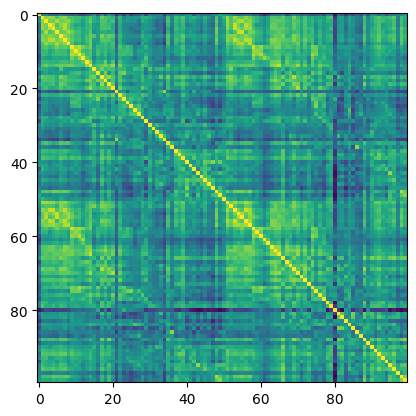

In [26]:
import matplotlib.pyplot as plt

plt.imshow(a[0][0].detach().cpu().numpy())
plt.show()

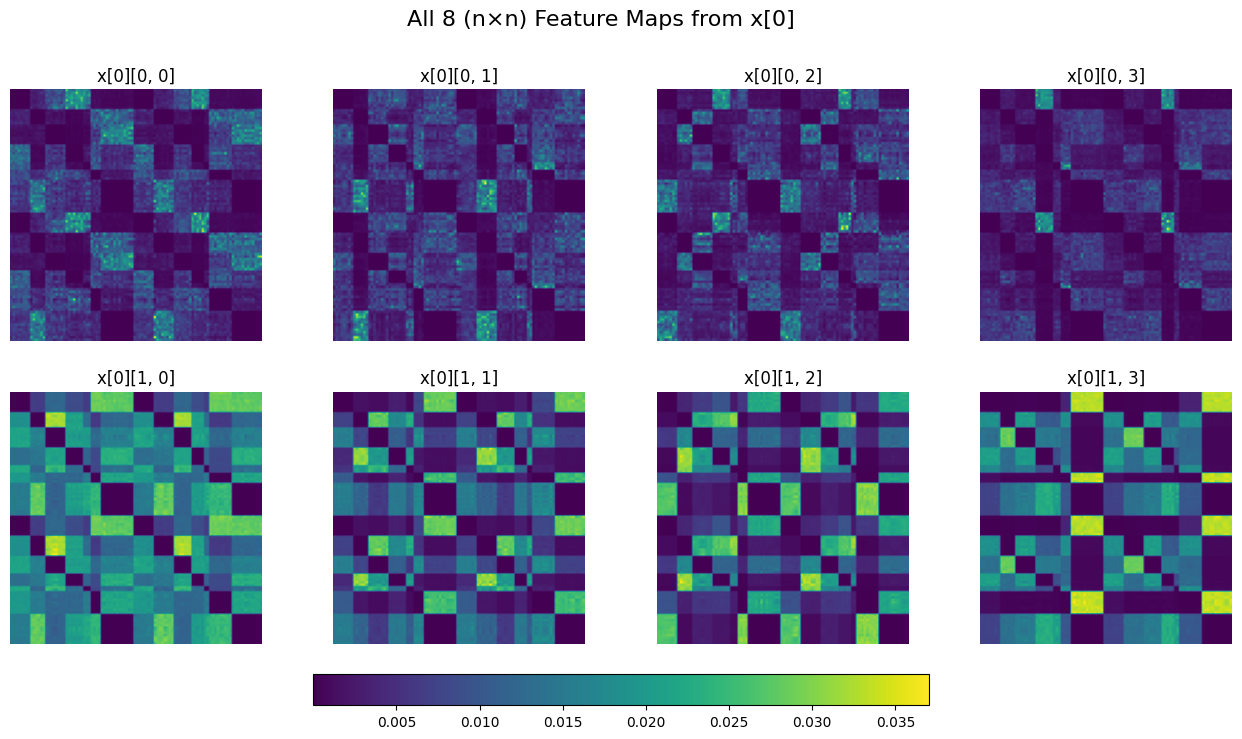

In [35]:
import torch
import matplotlib.pyplot as plt

# Example: x[0] has shape (2, 4, n, n)
n = 5
# x = torch.randn(8, 2, 4, n, n)  # Example tensor

# Get x[0] and convert to NumPy
x0_np = x[0].detach().cpu().numpy()  # shape: (2, 4, n, n)

# Set up the plot: 2 rows × 4 columns
fig, axes = plt.subplots(2, 4, figsize=(16, 8))

for i in range(2):
    for j in range(4):
        ax = axes[i, j]
        im = ax.imshow(x0_np[i, j], cmap='viridis')
        ax.set_title(f"x[0][{i}, {j}]")
        ax.axis('off')

fig.suptitle("All 8 (n×n) Feature Maps from x[0]", fontsize=16)
fig.colorbar(im, ax=axes, orientation='horizontal', fraction=0.05, pad=0.05)
# plt.tight_layout()
plt.show()
